In [11]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

import functools

TableForm = functools.partial(
    np.array2string,
    precision=4, suppress_small=True, formatter={'float': '{:0.4f}'.format}, max_line_width=100)

mreal = np.double
mcomplex = np.cdouble
    
# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.initialMass   = np.sum(np.abs(self.psi)**2) 
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS

    def computeMassLoss(self):
        return np.abs(np.sum(np.abs(self.psi)**2)/self.initialMass - 1)
    

class GramFFTExtensionScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 


        #self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        #self.Fe = self.F[:nD, :].astype(self.mreal) 
        #self.Fo = self.F[nD:, :].astype(self.mreal) 
        #self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal) 
        #self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal) 

        self.F = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/extension_tables/F_nD={nD}_nd={nd}_m={nD}_g={g}_Gamma={Gamma}.bin", dtype=np.float128).reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :].astype(self.mreal) 
        self.Fo = self.F[nD:, :].astype(self.mreal) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/polynomial_tables/Pleft_m={nD}_nD={nD}.bin", dtype=np.float128).reshape( nD, nD).astype(self.mreal) 
        self.Pr = np.fromfile(f"/home/calab912/Documents/SpectralInterpolation/gamer/tool/table_maker/GramFE/polynomial_tables/Pright_m={nD}_nD={nD}.bin", dtype=np.float128).reshape(nD, nD).astype(self.mreal) 
        self.proj   = config.get("projectionOrder", 5)
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar).astype(self.mcomplex)
        self.fields = self.psi.astype(self.mcomplex)
        self.counter = 0
        self.alpha   = config.get("alpha", 0) 
        self.p       = config.get("p", 1) 
        self.massrat = []

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta 

        psi = self.psi.astype(self.minput) 

        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 

        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        self.fdp = np.concatenate([fpl, f[nDelta:-nDelta], fpr, fmatch[nDelta:nDelta + self.nd]])

        self.massrat.append(np.sum(np.abs(psi)**2) / np.sum(np.abs(self.fdp)**2))
        fhat = scipy.fft.fft(self.fdp[:-2], workers=16)
        
        k = sd.computeK(fhat, self.dx, sd.PERIODIC)

        eta = np.abs(k / (np.max(np.abs(k))))
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        arg  = -Coeff1 * k**2
        fhat = fhat * (1 + arg + arg**2/2 + arg**3/6 + arg**4/24 + arg**5/60) 
        fhat = fhat.astype(self.mcomplex) 
        
        self.psi[self.ghostBoundarySize:-self.ghostBoundarySize] = scipy.fft.ifft(fhat, workers=16)[self.ghostBoundarySize:len(self.psi)-self.ghostBoundarySize]
        self.t += dt
        self.counter += 1 



    def getName(self):
        return "gram fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]

[1.5830872868950885283e-08, 1.5736723584787111201e-08, 1.6989509692586369164e-08, 1.0670204173531796603e-06, 4.6183518054758366944e-05, 0.00069447598883822113566, 0.0051599760295600259453, 0.025340286624320634686, 0.118268827461092612994, 0.16932872764244934808]
[4.0872250926593656444e-09, 7.740692520365548384e-09, 7.5429753025078494415e-08, 1.0709485654214367223e-06, 1.1342161877527412442e-05, 6.6975391394536883416e-05, 0.00038664182204615316232, 0.006022296952278634882, 0.048999068905433578878, 0.070792544056242249065]


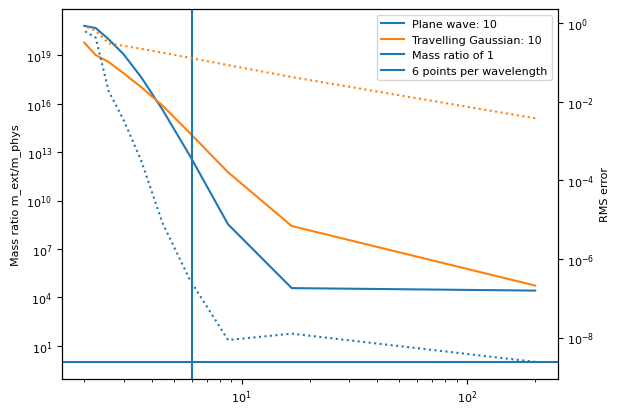

In [12]:
def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

def travellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/50, k= 5*np.pi, x0=.2):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

def periodicTravellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/50, k= 5*np.pi, x0=.2):
    psi = 0 + 0j
    N = 100
    L = 1
    for i in range(-N, N + 1):
        psi += travellingWavePacket(x + L * i, dx, t, m, hbar, alpha, k=k, x0=x0)
    return psi 

def standingWave(xx, dx, t, m = 1, hbar = 1,  k = 5*np.pi):
    omega = hbar/(2*m) * k**2
    return np.exp(1j*(k*xx - omega * t))


# Li test 3
def li3(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5, x1=.1):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x + x1 - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    psi += (
        C
        * np.exp(-((x - x1 - x0 + 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi


def periodicLi3(x, dx, t, m = 1, hbar = 1, alpha=1 / 500, k=1 * np.pi, x0=.5, x1=.2, eps=2):
    psi = eps + 0j
    N = 500
    L = 1
    for i in range(- N, N + 1):
        psi += li3(x + L * i, dx, t, m, hbar, alpha, k, x0, x1)

    psisq_mean = np.mean(np.abs(psi) ** 2)
    psi /= np.sqrt(psisq_mean) + 1e-8

    return psi


c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.01
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 1]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2

c["p"]                          = 50
c["alpha"]                      = 32 * np.log(10)
c["projectionOrder"]            = 14
c["extensionNDelta"]            = 14
c["extensionND"]                = 34
c["extensionGamma"]             = 150
c["extensionG"]                 = 63

c["inputPrecision"]             = np.csingle
c["realPrecision"]              = np.double
c["complexPrecision"]           = np.complex256

testproblems = [standingWave, periodicTravellingWavePacket]
testnames    = ["Plane wave", "Travelling Gaussian"]
iters = [10]
ks    = np.linspace(1, 2 * 16 * np.pi, 10) 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_ylabel("Mass ratio m_ext/m_phys")
ax2.set_ylabel("RMS error")
for problem, name in zip(testproblems, testnames): 
    for iter in iters:
        mass_ratio = []
        rms_errors  = []
        mass_losses  = []
        for k in ks: 
            s1 = GramFFTExtensionScheme(c, lambda xx, dx, t, m, hbar: problem(xx, dx, t, m, hbar, k=k))
            for i in range(iter): 
                s1.step(s1.getAdaptiveTimeStep())
            mass_ratio.append(1/s1.massrat[-1])
            rms_errors.append(s1.computeRMSError())
            mass_losses.append(s1.computeMassLoss())
        print(rms_errors)
        ax1.plot(32/(ks/(2*np.pi)), mass_ratio, ls="solid",  label=f"{name}: {iter}")
        #ax2.plot(32/(ks/(2*np.pi)), rms_errors, ls="dashed", label=f"{name}: {iter}")
        ax2.plot(32/(ks/(2*np.pi)), mass_losses, ls="dotted", label=f"{name}: {iter}")
plt.xlabel("Points per wavelength")
plt.xscale("log")
ax1.axhline(1, label = "Mass ratio of 1")
ax1.axvline(6, label = "6 points per wavelength")
ax1.legend()

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


NameError: name 'f' is not defined

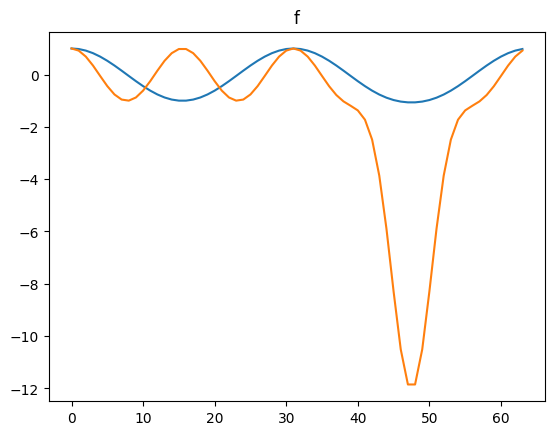

In [6]:


def extend(f, nd, nD, m): 
    g     = 63 
    Gamma = 150 
    nD    = nD
    nDelta = nD
    nd    = nd
    F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
    Fe = F[:nD, :]
    Fo = F[nD:, :]
    Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
    Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)


    fl = f[:nDelta]
    fr = f[-nDelta:]

    al     = Pl @ fl 
    ar     = Pr @ fr 


    al[m+1:] = 0
    ar[m+1:] = 0
    fpl    = al @ Pl 
    fpr    = ar @ Pr
    fmatch = (al + ar)/2 @ Fe + (ar - al)/2 @ Fo

    fdp = np.concatenate([fpl, f[nDelta:-nDelta], fpr, fmatch[nDelta:nDelta + nd]])
    return fdp[:-2]

N = 32
x = np.linspace(0, 1, N) 
omega = 2 * np.pi 
f1 = np.exp(1j * x * omega)

omega = 4 * np.pi 
f2 = np.exp(1j * x * omega)

omega = 5 * np.pi 
f3 = np.exp(1j * x * omega)

plt.title("f") 
fdp1 = extend(f1, 34, 14, 14)
fdp2 = extend(f2, 34, 14, 14)
fdp3 = extend(f3, 34, 14, 14)
plt.plot(fdp1)
plt.plot(fdp2)
#plt.plot(fdp3)
plt.plot(f)
plt.legend()
plt.show()

plt.title("Spectrum") 
fhat1 = scipy.fft.fft(fdp1, workers=16)
fhat2 = scipy.fft.fft(fdp2, workers=16)
fhat3 = scipy.fft.fft(fdp3, workers=16)
plt.plot(np.abs(fhat1))
plt.plot(np.abs(fhat2))
plt.plot(np.abs(fhat3))
plt.yscale("log")
plt.legend()
plt.show()

In [7]:
from scipy import stats
# Two-sided inverse Students t-distribution

# p - probability, df - degrees of freedom

from scipy.stats import t

tinv = lambda p, df: abs(t.ppf(p/2, df))

x     = np.linspace(0, 1, N) 
omega = 14 * np.pi 
f = np.exp(1j * x * omega)


logspec = np.log(np.abs(extendandfft@f))


N1    = 16
delta = 10
y1 = logspec[1 + N1 : N1 + 1 + delta]
x1  = np.arange(len(y1))


r1 = stats.linregress(x = x1, y = y1)
plt.title("Left slope")
plt.plot(x1, y1, 'o', label='original data')
plt.plot(x1, r1.intercept + r1.slope*x1, 'r', label='fitted line')
plt.legend()
plt.show()

ts = tinv(0.05, len(x1)-2)

print(f"slope (95%): {r1.slope:.6f} +/- {ts*r1.stderr:.6f}")


print(f"intercept (95%): {r1.intercept:.6f}"
      f" +/- {ts*r1.intercept_stderr:.6f}")



NameError: name 'extendandfft' is not defined

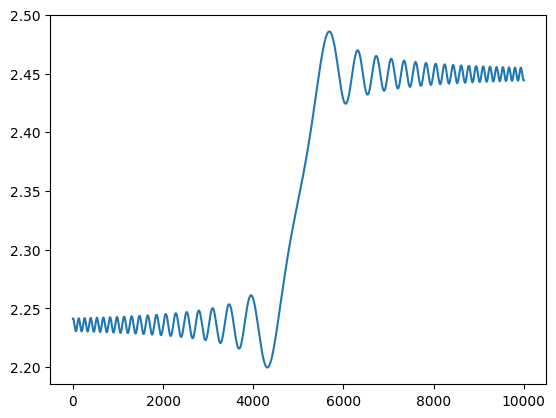

In [8]:
import scipy.special as sc 

def li2(x, dx, t, m = 1, hbar = 1, x0 = 0.5, A=np.sqrt(5)-np.sqrt(6), B=np.sqrt(6)):
    C, S = sc.fresnel((x-x0)*np.sqrt(1/(np.pi*t * hbar/m)))
    psi = A/2 + B - A/2*(1+1.j)*C - A/2*(1-1.j)*S
    return psi

def periodiLi2(x, dx, t, m = 1, hbar = 1, x0 = 1, A=np.sqrt(5)-np.sqrt(6), B=np.sqrt(6)):
    psi = 0
    N = 20
    L = 1
    for i in range(-N, N + 1):
      psi += li2(x + L * i, dx, t, m, hbar, x0, A, B)
    return psi


# Li test 3
def li3(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5, x1=.1):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x + x1 - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    psi += (
        C
        * np.exp(-((x - x1 - x0 + 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi


x = np.linspace(0, 1, 10000 )
dx = x[1]-x[0]

plt.plot(np.abs(li2(x, dx, 0.001)))

/tmp/ipykernel_2311159/1040449404.py:22: RuntimeWarning: divide by zero encountered in log
  logspec = np.log(spec)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


frequency:  0.01  y1:  [6.39559691e+01 1.30863340e+00 5.92057421e-01 3.38677101e-01
 2.05448255e-01 1.25054022e-01 7.44624552e-02 4.27481414e-02
 2.34312184e-02 1.21699879e-02 5.95035684e-03 2.72142383e-03
 1.15656410e-03 4.53379086e-04 1.62528398e-04 5.27240458e-05
 1.52721792e-05 3.88066641e-06 8.43799269e-07 1.51239806e-07
 2.09885654e-08 1.98746895e-09 8.68351106e-11 2.55940794e-12
 3.64262906e-14 3.31763381e-14 9.97969771e-15 1.96666619e-15
 1.06319163e-15 6.02376326e-16 9.38836448e-16 2.52918875e-16
 3.55964581e-15]  x1:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] slope:  -1.3319256602786642  intercept:  6.128323355219658
frequency:  0.010722672220103232  y1:  [6.39493721e+01 1.40520377e+00 6.35259847e-01 3.63299053e-01
 2.20357006e-01 1.34118853e-01 7.98560890e-02 4.58429450e-02
 2.51268750e-02 1.30504222e-02 6.38072394e-03 2.91821245e-03
 1.24018120e-03 4.86152292e-04 1.74275394e-04 5.65342880e-05
 1.63757387e-05 4.1610

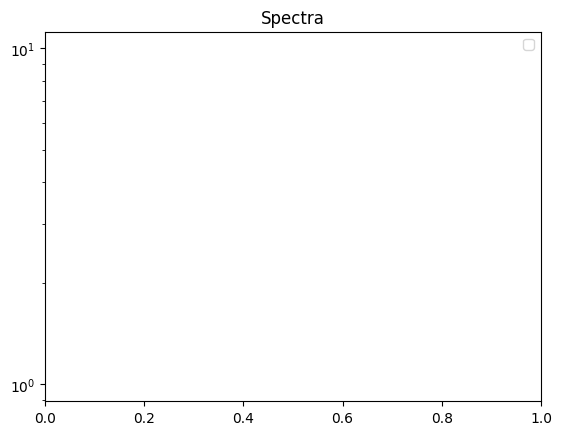

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


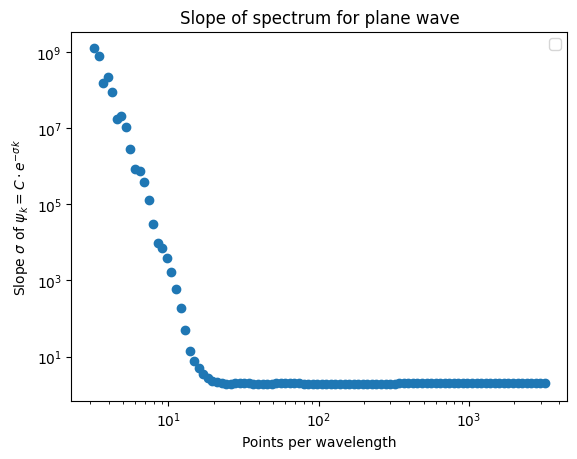

In [10]:
frequencies = np.logspace(-2, 1, 100)
slopes      = []


plt.title("Spectra") 
plt.yscale("log") 

for frequency in frequencies: 
    x     = np.linspace(0, 1, N) 
    omega = frequency * 2 * np.pi 
    f     = np.exp(1j * x * omega)#travellingWavePacket(x, x[1]-x[0], t=0, k = omega) * 1e4
    #spec = np.abs((extendandfft@f))[:33]
    fext  = extend(f, 34, 14, 14) 
    # select left side of spectrum 
    Ncut  = int(len(fext)/2)

    # compute spectrum 
    spec = np.abs(scipy.fft.fft(fext))[:Ncut+1]


    # compute logarithm of spectrum 
    logspec = np.log(spec)

    # input data for linear fit 
    ys  = logspec
    xs  = np.arange(len(ys))

    #ys  = np.array([np.max(logspec), logspec[-1]])
    #xs  = np.array([np.argmax(logspec), xs[-1]])
#
    #ys  = np.array([np.max(y1), np.min(y1)])
    #xs  = np.array([np.argmax(y1), np.argmin(y1)])

    r1 = stats.linregress(x = xs, y = ys)
    print("frequency: ", frequency, " y1: ", np.exp(ys), " x1: ", xs, "slope: ",  r1.slope, " intercept: ", r1.intercept)

    ##plt.plot(spec, label=f"PPW = {N / frequency}") 
    ##plt.plot(xs, np.exp(r1.intercept + r1.slope*xs), 'k',label=f'Fit PPW = {N / frequency}')

    # store slope
    slopes.append(np.sum(np.abs(fext))/np.sum(np.abs(f)))
plt.legend()
plt.show()

plt.title("Slope of spectrum for plane wave")
plt.xscale("log")
plt.xlabel("Points per wavelength")
plt.ylabel(r"Slope $\sigma$ of $\psi_k = C \cdot e^{-\sigma k}$")
plt.yscale("log")
plt.plot(32/frequencies, np.abs(slopes), 'o')
plt.legend()
plt.show()

In [ ]:

def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 






c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.1
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["alpha"]                      = 16 * np.log(10)
c["projectionOrder"]            = 14

c["extensionGamma"]             = 150
c["extensionG"]                 = 63

c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["extensionNDelta"]            = 14
c["extensionND"]                = 26
c["p"]                          = 50
c["inputPrecision"]             = np.cdouble

ks = np.linspace(0.1, 2 * np.pi * 16, 10000)
mass_loss1 = []
err1 = []
mass_loss2 = []
err2 = []
for k in ks: 
    #def standingWave(xx, dx, t, m = 1, hbar = 1,  k = k):
    #    omega = hbar/(2*m) * k**2
    #    return np.exp(1j*(k*xx - omega * t))

    gaussian = lambda x, dx, t, m, hbar: travellingWavePacket(x, dx, t, k=k) 
    s1 = GramExtensionScheme(c, gaussian)
    dt = s1.getAdaptiveTimeStep()
    mass_loss1.append(s1.step(dt))
    err1.append(s1.computeRMSError())
    s2 = GAMERScheme(c, gaussian)
    mass_loss2.append(s2.step(dt))
    err2.append(s2.computeRMSError())

In [102]:

y2 = logspec[N1 + 1 + delta + 1: N2]
x2  = np.arange(len(y2))
r2 = stats.linregress(x = x2, y = y2)


plt.title("Right slope")
plt.plot(x2, y2, 'o', label='original data')
plt.plot(x2, r2.intercept + r2.slope*x2, 'r', label='fitted line')
plt.legend()
plt.show()


ts = tinv(0.05, len(x2)-2)

print(f"slope (95%): {r2.slope:.6f} +/- {ts*r2.stderr:.6f}")


print(f"intercept (95%): {r2.intercept:.6f}"
      f" +/- {ts*r2.intercept_stderr:.6f}")

NameError: name 'N2' is not defined

In [141]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 


class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    
class GramExtensionScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :].astype(self.mreal) 
        self.Fo = self.F[nD:, :].astype(self.mreal) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal) 
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal) 

        self.proj   = config.get("projectionOrder", 5)
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar).astype(self.mcomplex)
        self.fields = self.psi.astype(self.mcomplex)
        self.counter = 0
        self.alpha   = config.get("alpha", 0) 
        self.p       = config.get("p", 1) 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta 

        psi = self.psi.astype(self.minput) 

        mass_before = np.sum(np.abs(psi)[2:-2])
        
        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 


        al[self.proj+1:] = 0
        ar[self.proj+1:] = 0
        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([fpl, f[nDelta:-nDelta], fpr, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)
        fhat = scipy.fft.fft(fdp[:-2], workers=16).astype(self.mcomplex) 
        
        k = sd.computeK(fhat, self.dx, sd.PERIODIC).astype(self.mcomplex) 

        eta = np.abs(k / (np.max(np.abs(k))))
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        arg  = -Coeff1 * k**2
        fhat = fhat * (1 + arg + arg**2/2 + arg**3/6 + arg**4/24 + arg**5/120) 
        fhat = fhat.astype(self.mcomplex) 
        
        self.psi = scipy.fft.ifft(fhat, workers=16)[:len(self.psi)].astype(self.minput)
        mass_after = np.sum(np.abs(self.psi)[2:-2]) 

        #print("Relative mass loss: ", mass_after/mass_before)
        self.t += dt
        self.counter += 1 
        return mass_after/mass_before



    def getName(self):
        return "gram fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    

def LAP1(f, axis = 0):
    fm4 = np.roll(f, 4 * fd.ROLL_L, axis=axis)
    fm3 = np.roll(f, 3 * fd.ROLL_L, axis=axis)
    fm2 = np.roll(f, 2 * fd.ROLL_L, axis=axis)
    fm1 = np.roll(f, 1 * fd.ROLL_L, axis=axis)
    fp4 = np.roll(f, 4 * fd.ROLL_R, axis=axis)
    fp3 = np.roll(f, 3 * fd.ROLL_R, axis=axis)
    fp2 = np.roll(f, 2 * fd.ROLL_R, axis=axis)
    fp1 = np.roll(f, 1 * fd.ROLL_R, axis=axis)
    return 1.0/12.0 * ( - fm2 + 16.0*fm1 - 30.0*f - fp2 + 16.0*fp1 )

def LAP2(f, axis = 0): 
    fm4 = np.roll(f, 4 * fd.ROLL_L, axis=axis)
    fm3 = np.roll(f, 3 * fd.ROLL_L, axis=axis)
    fm2 = np.roll(f, 2 * fd.ROLL_L, axis=axis)
    fm1 = np.roll(f, 1 * fd.ROLL_L, axis=axis)
    fp4 = np.roll(f, 4 * fd.ROLL_R, axis=axis)
    fp3 = np.roll(f, 3 * fd.ROLL_R, axis=axis)
    fp2 = np.roll(f, 2 * fd.ROLL_R, axis=axis)
    fp1 = np.roll(f, 1 * fd.ROLL_R, axis=axis)
    return 1.0/144.0 * ( + fm4 - 32.0*fm3 + 316.0*fm2 - 992.0*fm1 + fp4 - 32.0*fp3 + 316.0*fp2 - 992.0*fp1 +  1414.0*f )

class GAMERScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        
    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)
        dx, u0 = self.dx, self.psi
        mass_before = np.sum(np.abs(self.psi)[2:-2])
        _Eta = self.eta 
        _dh  = 1/dx 
        Taylor3_Coeff = 1/6
        dT           = 0.5*dt*_Eta
        _Eta2_dh     = 0.5*_dh*_Eta
        Coeff1       = dT*_dh*_dh
        Coeff2       = Taylor3_Coeff*Coeff1**2


        re0 = np.real(u0)
        im0 = np.imag(u0)

        re1 = re0 - 0.5*Coeff1*LAP1( im0 ) - Coeff2*LAP2( re0 )
        im1 = im0 + 0.5*Coeff1*LAP1( re0 ) - Coeff2*LAP2( im0 )

        re2   = re0 - Coeff1*LAP1( im1 )
        im2   = im0 + Coeff1*LAP1( re1 )

        self.psi = re2 + 1j * im2
        self.t += dt
        mass_after = np.sum(np.abs(self.psi)[2:-2]) 
        return mass_after/mass_before

    def getName(self):
        return "gamer scheme"
    

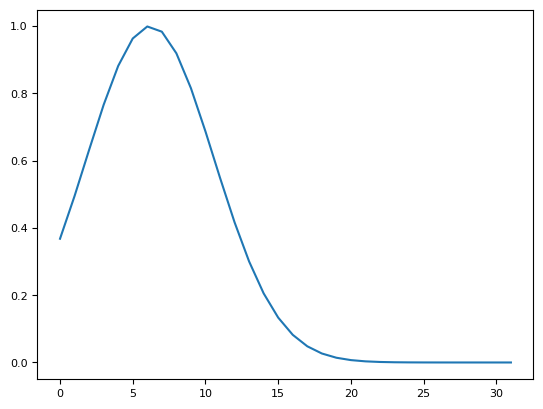

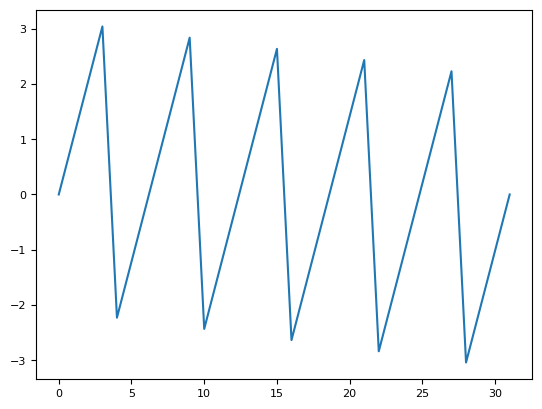

In [147]:
def travellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/50, k= 5*np.pi, x0=.2):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

x = np.linspace(0, 1, 32) 
dx = x[1] - x[0]

psi = travellingWavePacket(x, dx, t=0, k = 10*np.pi)
plt.plot(np.abs(psi))
plt.show()
plt.plot(np.angle(psi))
plt.show()

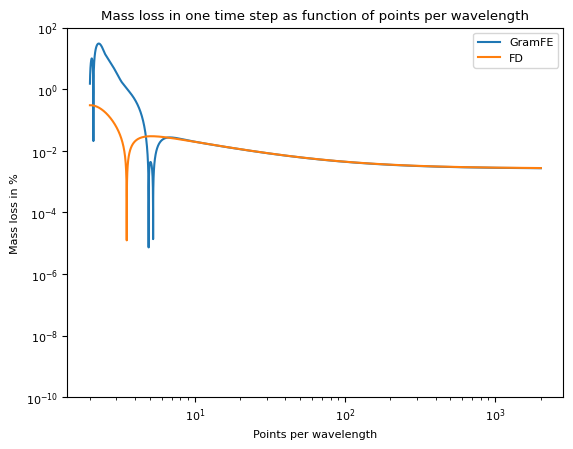

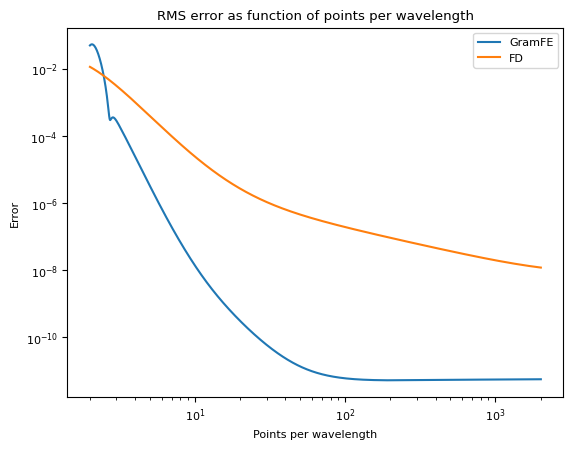

In [150]:

def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 






c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.1
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["alpha"]                      = 16 * np.log(10)
c["projectionOrder"]            = 14

c["extensionGamma"]             = 150
c["extensionG"]                 = 63

c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["extensionNDelta"]            = 14
c["extensionND"]                = 26
c["p"]                          = 50
c["inputPrecision"]             = np.cdouble

ks = np.linspace(0.1, 2 * np.pi * 16, 10000)
mass_loss1 = []
err1 = []
mass_loss2 = []
err2 = []
for k in ks: 
    #def standingWave(xx, dx, t, m = 1, hbar = 1,  k = k):
    #    omega = hbar/(2*m) * k**2
    #    return np.exp(1j*(k*xx - omega * t))

    gaussian = lambda x, dx, t, m, hbar: travellingWavePacket(x, dx, t, k=k) 
    s1 = GramExtensionScheme(c, gaussian)
    dt = s1.getAdaptiveTimeStep()
    mass_loss1.append(s1.step(dt))
    err1.append(s1.computeRMSError())
    s2 = GAMERScheme(c, gaussian)
    mass_loss2.append(s2.step(dt))
    err2.append(s2.computeRMSError())

ppw = 32 * 2 * np.pi / ks
plt.title("Mass loss in one time step as function of points per wavelength") 
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e-10, 1e2])
plt.xlabel("Points per wavelength")
plt.ylabel("Mass loss in %")
plt.plot(ppw, 100 * np.abs( 1 - np.array(mass_loss1)), label="GramFE")
plt.plot(ppw, 100 * np.abs( 1 - np.array(mass_loss2)), label="FD")
plt.legend()
plt.show()


plt.title("RMS error as function of points per wavelength") 
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Points per wavelength")
plt.ylabel("Error")
plt.plot(ppw, err1, label="GramFE")
plt.plot(ppw, err2, label="FD")
plt.legend()
plt.show()



In [135]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 
c["tEnd"] = 0.0011
s = GAMERScheme(c, periodic1DGaussian)
for i in range(100):
    s.step(1e-4)

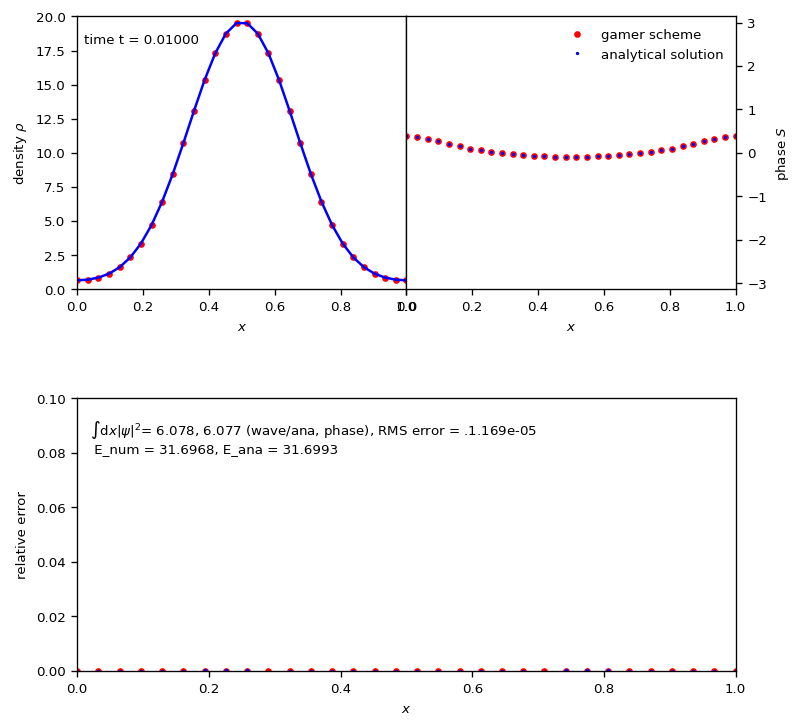

In [136]:
animation.drawFrame(s)